# DPU : Resnet50 trained on Tipu12
----

## 0. Extract dataset
We extract the dataset if needed.

In [5]:
import tarfile
import os

# Define the file paths
tar_xz_file = 'test_tipu12.tar.xz'
extract_path = 'tipu12'

# Extract the tar.xz file
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    
    with tarfile.open(tar_xz_file, 'r:xz') as tar:
        tar.extractall(path=extract_path)
    print(f'Files extracted to path: {extract_path}')
else:
    print(f'Files already exist in path: {extract_path}')

Files already exist in path: tipu12


## 1. Prepare the overlay
We will download the overlay onto the board. 

In [6]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("overlays/dpu.bit")

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [7]:
import os
import time
import numpy as np
import threading
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
%matplotlib inline

The `load_model()` method will automatically prepare the `graph`
which is used by VART. It takes the `.xmodel` in argument.

In [8]:
overlay.load_model("ultra96v2_tipu12.xmodel")

We first define our preprocessing functions. These functions need to be the same ones as used for traing the model.

In [9]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

MEANS = [_B_MEAN,_G_MEAN,_R_MEAN]

def resize_shortest_edge(image, size):
    H, W = image.shape[:2]
    if H >= W:
        nW = size
        nH = int(float(H)/W * size)
    else:
        nH = size
        nW = int(float(W)/H * size)
    return cv2.resize(image,(nW,nH))

def mean_image_subtraction(image, means):
    B, G, R = cv2.split(image)
    B = B - means[0]
    G = G - means[1]
    R = R - means[2]
    image = cv2.merge([R, G, B])
    return image

def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    return image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]

def normalize(image):
    image=image/256.0
    image=image-0.5
    image=image*2
    return image

def preprocess_fn(image, image_path, crop_height = 224, crop_width = 224):
    if image is None:
        raise ValueError(f"Error reading image at {image_path}")
    image = resize_shortest_edge(image, 256)
    #image = mean_image_subtraction(image, MEANS)
    image = central_crop(image, crop_height, crop_width)
    image = BGR2RGB(image)
    image = normalize(image)
    return image

We will also define a few functions to calculate softmax and provide 
the output class after running a DPU task.

In [10]:
def calculate_softmax(data):
    e_x = np.exp(data - np.max(data))
    return e_x / e_x.sum()

def predict_label_name(softmax, class_file):
    with open(class_file, "r") as f:
        lines = f.readlines()
        lines = [item.strip() for item in lines]
        class_arg = np.argmax(softmax)
        class_name = lines[class_arg]
    return class_name

def predict_label_arg(softmax):
    class_arg = np.argmax(softmax)
    return class_arg

def get_line_number(class_file, class_name):
    with open(class_file, 'r') as file:
        lines = file.readlines()
        for idx, line in enumerate(lines):
            if line.strip() == class_name:
                return idx

    return -1 

## 3. Use VART
Now we should be able to use VART to do image classification.

Let's first define a few useful functions.

In [11]:
def count_total_images(dataset_folder):
    total = 0
    for class_folder in os.listdir(dataset_folder):
        class_path = os.path.join(dataset_folder, class_folder)
        if os.path.isdir(class_path):
            total += len(os.listdir(class_path))
    return total

def count_directories(directory_path):
    count = 0
    for item in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item)
        if os.path.isdir(item_path):
            count += 1
    return count

def is_image_file(file_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    ext = os.path.splitext(file_path)[-1].lower()
    return ext in valid_extensions
    
def load_preprocess_images(class_folder, class_path, cnt, preprocessed_images0, label_names_list0, label_names, show_all_info):
    class_label = class_folder
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        # Skip non-image files (e.g., .ipynb_checkpoints)
        if not is_image_file(image_path):
            print("issue")
            continue

        # Preprocess image
        preprocessed_images0.append(preprocess_fn(cv2.imread(image_path), image_path))
        label_names_list0.append(class_label)
        cnt[0] = cnt[0] + 1
            
    label_names.append(class_label)
    if ((cnt[0] != 0) & (show_all_info==True)):
        print("Number of preprocessed images: ", cnt[0])
    print("Load and preprocess over.")
    
def runDPU(runner, img, labels, class_file, realCorrect, class_accuracy, label_arg, nb_images_per_class, predictions_list, labels_list, show_all_info, shapeIn, shapeOut, outputSize):
    time_start = time.time()
    
    n_of_images = len(img)
    count = 0
    correct = 0
    while count < n_of_images:
        inputData = [np.empty(shapeIn, dtype=np.float32, order="C")]
        outputData = [np.empty(shapeOut, dtype=np.float32, order="C")]

        imageRun = inputData[0]
        imageRun[0, ...] = img[count % n_of_images].reshape(shapeIn[1:])

        job_id = runner.execute_async(inputData, outputData)
        runner.wait(job_id)
        
        # Process output and calculate softmax
        temp = [j.reshape(1, outputSize) for j in outputData]
        softmax = calculate_softmax(temp[0][0])
        predicted_label_name = predict_label_name(softmax, class_file)
        
        # To compute f1 score later on
        predictions_list.append(predicted_label_name)
        labels_list.append(labels[0])
        
        if predicted_label_name == labels[0]:
            correct += 1
            class_accuracy[label_arg] += 1
            
        count += 1
        
    nb_images_per_class[label_arg] = nb_images_per_class[label_arg] + n_of_images
    class_accuracy[label_arg] = class_accuracy[label_arg]
    realCorrect[0] = realCorrect[0] + correct
    if show_all_info==True:
        print("Correct : ", realCorrect[0])

The following `test_accuracy` function determines the accuracy, accuracy per class and speed (FPS) of our model on DPU. Depending on the RAM available on your board, you won't be able to process all of your images at once. This function re-creates the threads for every classes to limit memory usage. 

In [12]:
def test_accuracy(overlay, image_folder, num_classes, num_thread, show_all_info, class_file):
    print(f"Number of threads: {num_thread} \n")
    
    # Define our buffers
    all_dpu_runners = []
    for i in range(num_thread):
        all_dpu_runners.append(overlay.runner)

    inputTensors = all_dpu_runners[0].get_input_tensors()
    outputTensors = all_dpu_runners[0].get_output_tensors()

    shapeIn = tuple(inputTensors[0].dims)
    shapeOut = tuple(outputTensors[0].dims)
    outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

    softmax = np.empty(outputSize)
    
    # Initialization
    time_inf = 0
    totaltime_preprocess = 0
    realCorrect = [0]
    cnt = [0]
    nb_images_per_class = np.zeros((num_classes,))
    class_accuracy = np.zeros((num_classes,))
    preprocessed_images0 = []
    label_names_list0 = []
    label_names = []
    predictions_list = []
    labels_list = []
    
    total_images = count_total_images(image_folder)
    
    
    time_start = time.time()
    for class_folder in os.listdir(image_folder):
        class_path = os.path.join(image_folder, class_folder)

        threadAll = []
        preprocessed_images0 = []
        label_names_list0 = []
        
        # Preprocessing
        time_start_preprocess = time.time()
        load_preprocess_images(class_folder, class_path, cnt, preprocessed_images0, label_names_list0, label_names, show_all_info)
        time_end_preprocess = time.time()
        totaltime_preprocess = totaltime_preprocess + time_end_preprocess-time_start_preprocess
        if show_all_info==True:
            print(f"Total time preprocess: {totaltime_preprocess:.2f} seconds")

        label_arg = get_line_number(class_file, label_names_list0[0])

        # Define number of images to send to threads
        if num_thread == 1:
            start = [0]
            end = [len(preprocessed_images0)]

        elif num_thread == 2:
            if len(preprocessed_images0)%2 == 0:
                start = [0, int(len(preprocessed_images0)/2)]
                end = [int(len(preprocessed_images0)/2), len(preprocessed_images0)]
            else:
                start = [0, int(len(preprocessed_images0)/2)+1]
                end = [int(len(preprocessed_images0)/2)+1, len(preprocessed_images0)]

        elif num_thread == 3:
            if len(preprocessed_images0)%3 == 0:
                start = [0, int(len(preprocessed_images0)/3), 2*int(len(preprocessed_images0)/3)]
                end = [int(len(preprocessed_images0)/3), 2*int(len(preprocessed_images0)/3), len(preprocessed_images0)]
            elif len(preprocessed_images0)%3 == 1:
                start = [0, int(len(preprocessed_images0)/3)+1, 2*int(len(preprocessed_images0)/3)]
                end = [int(len(preprocessed_images0)/3)+1, 2*int(len(preprocessed_images0)/3), len(preprocessed_images0)]
            elif len(preprocessed_images0)%3 == 2:
                start = [0, int(len(preprocessed_images0)/3)+1, 2*int(len(preprocessed_images0)/3)+1]
                end = [int(len(preprocessed_images0)/3)+1, 2*int(len(preprocessed_images0)/3)+1, len(preprocessed_images0)]

        elif num_thread == 4:
            if len(preprocessed_images0)%4 == 0:
                start = [0, int(len(preprocessed_images0)/4), 2*int(len(preprocessed_images0)/4), 3*int(len(preprocessed_images0)/4)]
                end = [int(len(preprocessed_images0)/4), 2*int(len(preprocessed_images0)/4), 3*int(len(preprocessed_images0)/4), len(preprocessed_images0)]
            elif len(preprocessed_images0)%4 == 1:
                start = [0, int(len(preprocessed_images0)/4)+1, 2*int(len(preprocessed_images0)/4), 3*int(len(preprocessed_images0)/4)]
                end = [int(len(preprocessed_images0)/4)+1, 2*int(len(preprocessed_images0)/4), 3*int(len(preprocessed_images0)/4), len(preprocessed_images0)]
            elif len(preprocessed_images0)%4 == 2:
                start = [0, int(len(preprocessed_images0)/4)+1, 2*int(len(preprocessed_images0)/4)+1, 3*int(len(preprocessed_images0)/4)]
                end = [int(len(preprocessed_images0)/4)+1, 2*int(len(preprocessed_images0)/4)+1, 3*int(len(preprocessed_images0)/4), len(preprocessed_images0)]
            elif len(preprocessed_images0)%4 == 3:
                start = [0, int(len(preprocessed_images0)/4)+1, 2*int(len(preprocessed_images0)/4)+1, 3*int(len(preprocessed_images0)/4)+1]
                end = [int(len(preprocessed_images0)/4)+1, 2*int(len(preprocessed_images0)/4)+1, 3*int(len(preprocessed_images0)/4)+1, len(preprocessed_images0)]


        time_start_inf = time.time()
        
        # Create and start threads
        for i in range(num_thread):
            t1 = threading.Thread(target=runDPU, args=(all_dpu_runners[i], preprocessed_images0[start[i]:end[i]], label_names_list0[start[i]:end[i]], class_file, realCorrect, class_accuracy, label_arg, nb_images_per_class, predictions_list, labels_list, show_all_info, shapeIn, shapeOut, outputSize))
            threadAll.append(t1)
        for x in threadAll:
            x.start()
        for x in threadAll:
            x.join()

        time_end_inf = time.time()
        time_inf = time_inf + time_end_inf - time_start_inf

        # Clear images, labels and threads to limit memory usage
        preprocessed_images0.clear()
        label_names_list0.clear()
        threadAll.clear()

        print(f"Done for class: {class_folder} \n")

       
    time_end = time.time()
    timetotal = time_end - time_start

    del all_dpu_runners
    
    # Computes accuracy and accuracy per class
    accuracy = realCorrect[0]/total_images
    for i in range(len(class_accuracy)):
        class_accuracy[i] = class_accuracy[i]/nb_images_per_class[i]

    print("Total processed images: ", cnt[0])
    print(f"Correct: {realCorrect[0]}/{cnt[0]}")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Total time: {timetotal:.2f} seconds")
    print(f"FPS total: {total_images/timetotal:.2f}")
    print(f"FPS during inference: {total_images/time_inf:.2f}")
    print(f"FPS during preprocess + inference: {total_images/(time_inf+totaltime_preprocess):.2f}")
    
    return accuracy, class_accuracy, label_names, predictions_list, labels_list

The following functions plot graphs including accuracy per class, confusion matrix and f1 score. 

In [13]:
def plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread):
    # Normalize accuracies for colormap
    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap='RdYlGn', norm=norm)
    sm.set_array([])

    class_accuracy_denormalized = [acc * 100 for acc in class_accuracy]

    # Attribute colors depending on accuracies value
    colors = [sm.to_rgba(acc) for acc in class_accuracy]

    # Create graph
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    if num_thread == 1:
        plt.title(f'Accuracy per Class - {board} - {num_thread} thread')
    else:
        plt.title(f'Accuracy per Class - {board} - {num_thread} threads')
    plt.xticks(rotation=90) 
    plt.colorbar(sm, ax=ax, label='Accuracy')

    # Add accuracy on top
    for i, acc in enumerate(class_accuracy_denormalized):
        ax.text(i, acc + 2, f'{acc:.2f}%', ha='center', va='bottom')

    # Add mean accuracy
    plt.text(len(class_names) - 1, max(class_accuracy_denormalized) + 5, f'Mean Accuracy: {accuracy * 100:.2f}%', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

    plt.tight_layout()
    plt.savefig(f'results/accuracy_per_class_{board}_{num_thread}_thread.png')
    plt.show()

In [14]:
def confusion_matrix_stats(conf_mat):
    # Counting true positives, false positives, true negatives, and false negatives
    true_positives = np.diag(conf_mat)
    false_positives = np.sum(conf_mat, axis=1) - true_positives
    false_negatives = np.sum(conf_mat, axis=0) - true_positives
    true_negatives = np.sum(conf_mat) - true_positives - false_positives - false_negatives
    # F1 Score
    f1_score = np.where((true_positives + false_positives + false_negatives) > 0, 2 * true_positives / (2 * true_positives + false_positives + false_negatives), 0)
    
    return f1_score, true_positives, false_positives, false_negatives, true_negatives

def compute_f1_score(labels_list, predictions_list):
    conf_mat = confusion_matrix(labels_list, predictions_list)
    f1_score, true_positives, false_positives, false_negatives, true_negatives = confusion_matrix_stats(conf_mat)
    f1_score_mean = np.mean(f1_score[:])
    
    return conf_mat, f1_score, f1_score_mean

def plot_f1_score(class_names, f1_score, f1_score_mean, num_thread, board):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    if num_thread == 1:
        plt.title(f'F1 Score per Class - {board} - {num_thread} thread')
    else:
        plt.title(f'F1 Score per Class - {board} - {num_thread} threads')
    plt.xticks(rotation=90) 

    # Add the mean F1 score line
    plt.axhline(f1_score_mean, color='red', linestyle='--', label=f'Mean F1 Score: {f1_score_mean:.3f}')

    # Adding the exact F1 score values on top of the bars
    for i, score in enumerate(f1_score):
        ax.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

    # Add a legend for the mean line
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'results/f1_score_per_class_{board}_{num_thread}_thread.png')
    plt.show()
    
def plot_confusion_matrix(conf_mat, class_names, num_thread, board):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    if num_thread == 1:
        plt.title(f'Confusion Matrix - {board} - {num_thread} thread')
    else:
        plt.title(f'Confusion Matrix - {board} - {num_thread} threads')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'results/confusion_matrix_{board}_{num_thread}_thread.png')
    plt.show()

Finally, this cell will execute all the code.

Number of threads: 1 

Load and preprocess over.
Done for class: Phasmida 

Load and preprocess over.
Done for class: Orthoptera 

Load and preprocess over.
Done for class: Coleoptera 

Load and preprocess over.
Done for class: Hemiptera 

Load and preprocess over.
Done for class: Diptera 

Load and preprocess over.
Done for class: Mantodea 

Load and preprocess over.
Done for class: Odonata 

Load and preprocess over.
Done for class: Megaloptera 

Load and preprocess over.
Done for class: Neuroptera 

Load and preprocess over.
Done for class: Trichoptera 

Load and preprocess over.
Done for class: Lepidoptera 

Load and preprocess over.
Done for class: Hymenoptera 

Total processed images:  3232
Correct: 2345/3232
Accuracy: 72.56%
Total time: 182.34 seconds
FPS total: 17.73
FPS during inference: 23.38
FPS during preprocess + inference: 17.83


/tmp/ipykernel_2816/3651357094.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


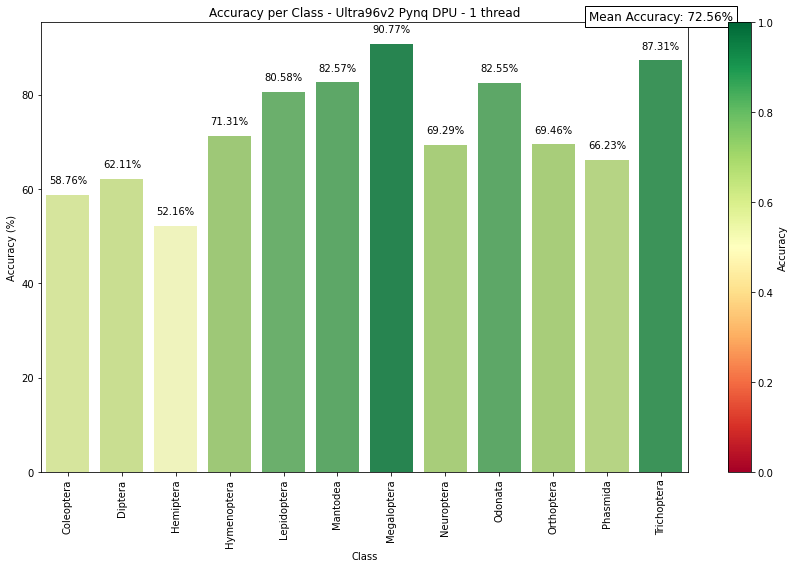

/tmp/ipykernel_2816/2662225642.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")


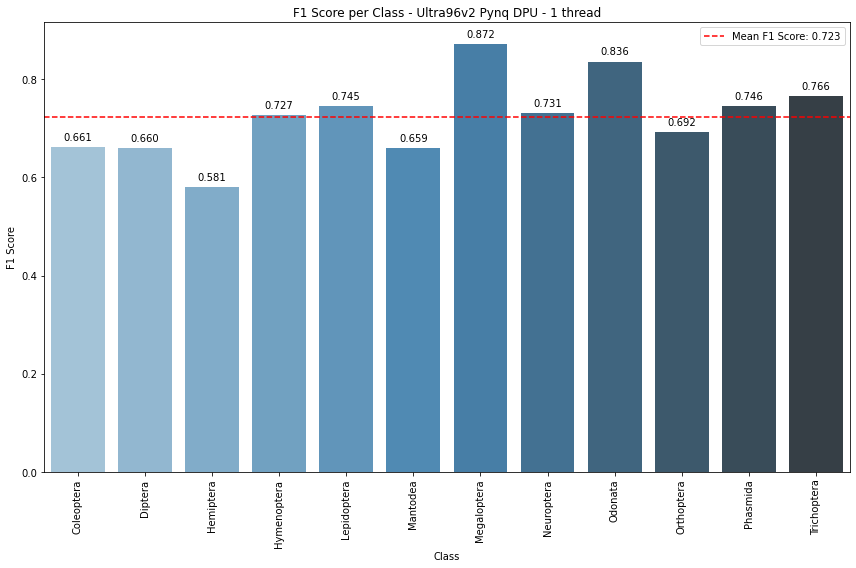

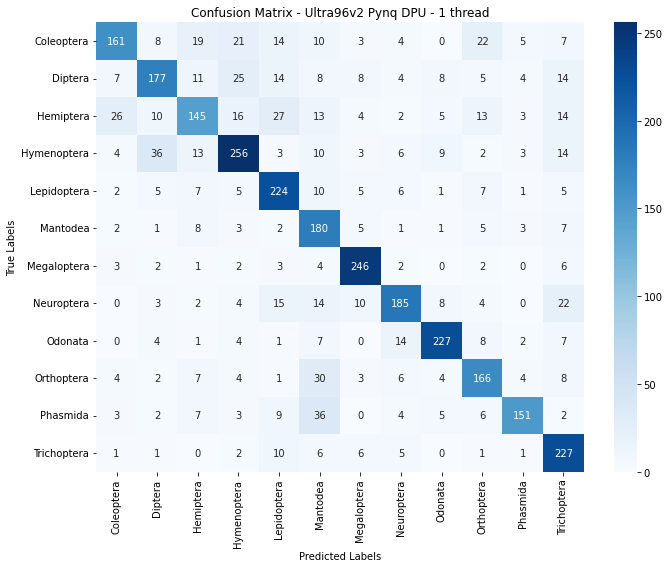

Number of threads: 2 

Load and preprocess over.
Done for class: Phasmida 

Load and preprocess over.
Done for class: Orthoptera 

Load and preprocess over.
Done for class: Coleoptera 

Load and preprocess over.
Done for class: Hemiptera 

Load and preprocess over.
Done for class: Diptera 

Load and preprocess over.
Done for class: Mantodea 

Load and preprocess over.
Done for class: Odonata 

Load and preprocess over.
Done for class: Megaloptera 

Load and preprocess over.
Done for class: Neuroptera 

Load and preprocess over.
Done for class: Trichoptera 

Load and preprocess over.
Done for class: Lepidoptera 

Load and preprocess over.
Done for class: Hymenoptera 

Total processed images:  3232
Correct: 2345/3232
Accuracy: 72.56%
Total time: 177.42 seconds
FPS total: 18.22
FPS during inference: 24.61
FPS during preprocess + inference: 18.35


/tmp/ipykernel_2816/3651357094.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


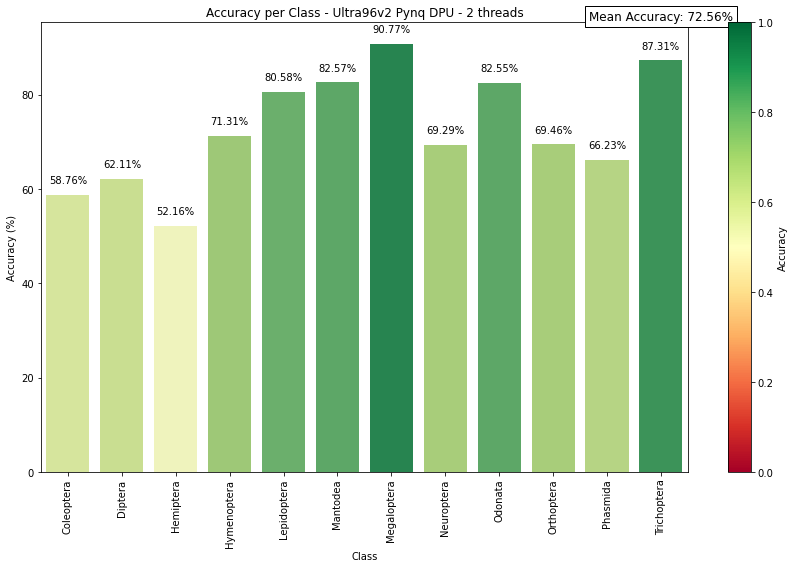

/tmp/ipykernel_2816/2662225642.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")


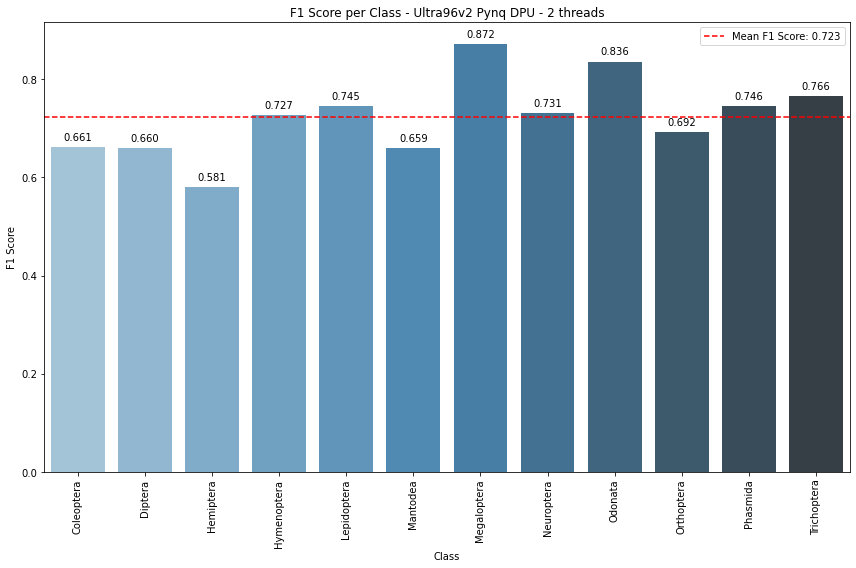

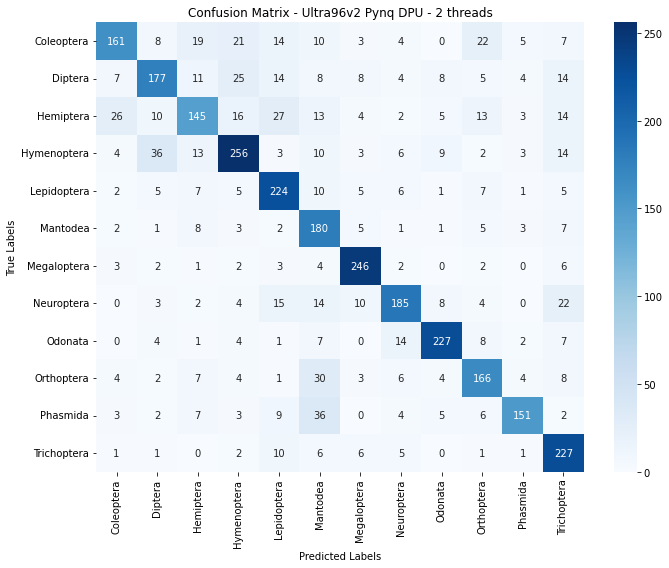

Number of threads: 3 

Load and preprocess over.
Done for class: Phasmida 

Load and preprocess over.
Done for class: Orthoptera 

Load and preprocess over.
Done for class: Coleoptera 

Load and preprocess over.
Done for class: Hemiptera 

Load and preprocess over.
Done for class: Diptera 

Load and preprocess over.
Done for class: Mantodea 

Load and preprocess over.
Done for class: Odonata 

Load and preprocess over.
Done for class: Megaloptera 

Load and preprocess over.
Done for class: Neuroptera 

Load and preprocess over.
Done for class: Trichoptera 

Load and preprocess over.
Done for class: Lepidoptera 

Load and preprocess over.
Done for class: Hymenoptera 

Total processed images:  3232
Correct: 2345/3232
Accuracy: 72.56%
Total time: 172.72 seconds
FPS total: 18.71
FPS during inference: 24.59
FPS during preprocess + inference: 18.85


/tmp/ipykernel_2816/3651357094.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


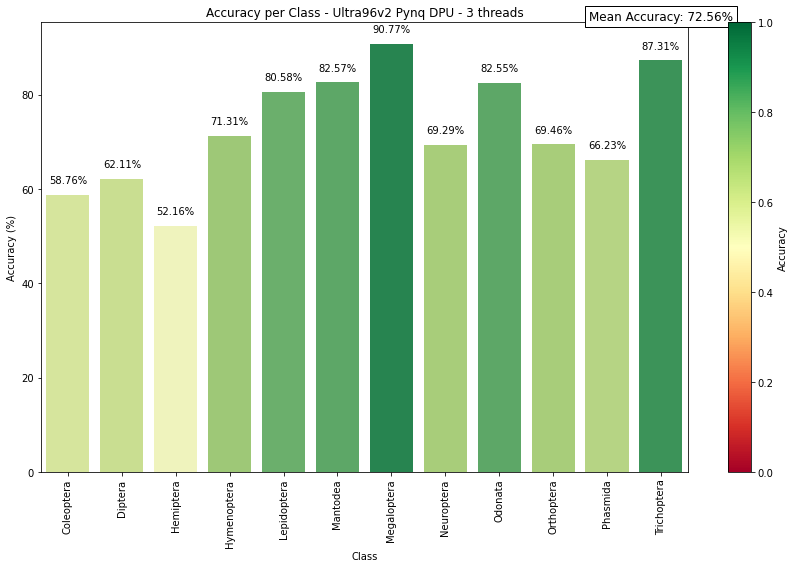

/tmp/ipykernel_2816/2662225642.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")


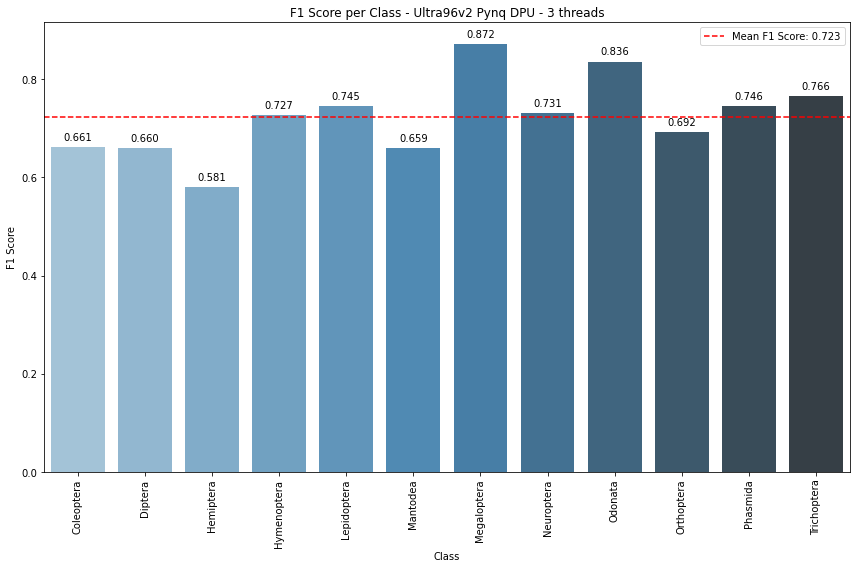

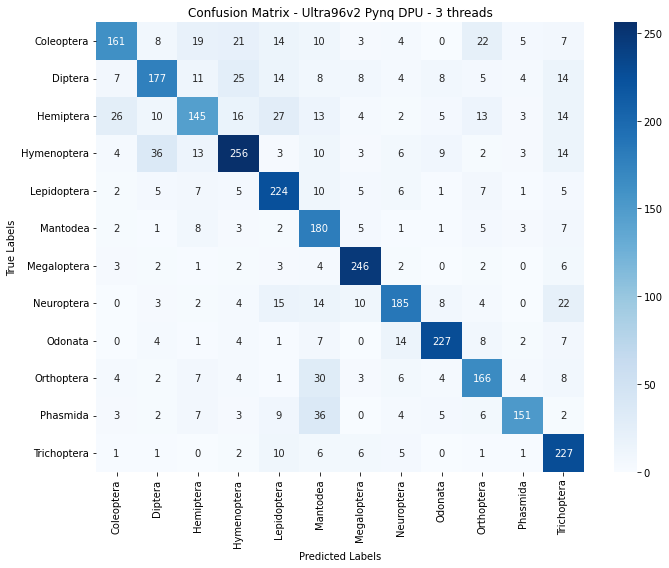

Number of threads: 4 

Load and preprocess over.
Done for class: Phasmida 

Load and preprocess over.
Done for class: Orthoptera 

Load and preprocess over.
Done for class: Coleoptera 

Load and preprocess over.
Done for class: Hemiptera 

Load and preprocess over.
Done for class: Diptera 

Load and preprocess over.
Done for class: Mantodea 

Load and preprocess over.
Done for class: Odonata 

Load and preprocess over.
Done for class: Megaloptera 

Load and preprocess over.
Done for class: Neuroptera 

Load and preprocess over.
Done for class: Trichoptera 

Load and preprocess over.
Done for class: Lepidoptera 

Load and preprocess over.
Done for class: Hymenoptera 

Total processed images:  3232
Correct: 2345/3232
Accuracy: 72.56%
Total time: 173.22 seconds
FPS total: 18.66
FPS during inference: 24.55
FPS during preprocess + inference: 18.79


/tmp/ipykernel_2816/3651357094.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


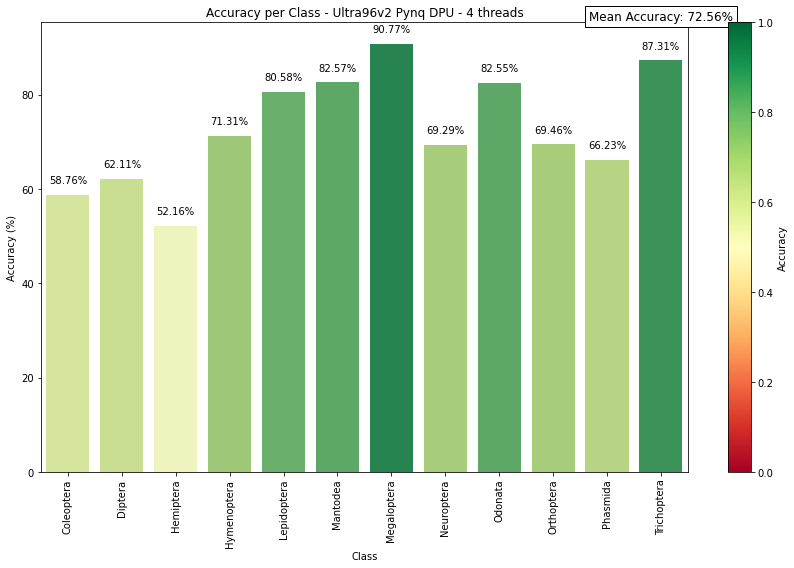

/tmp/ipykernel_2816/2662225642.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")


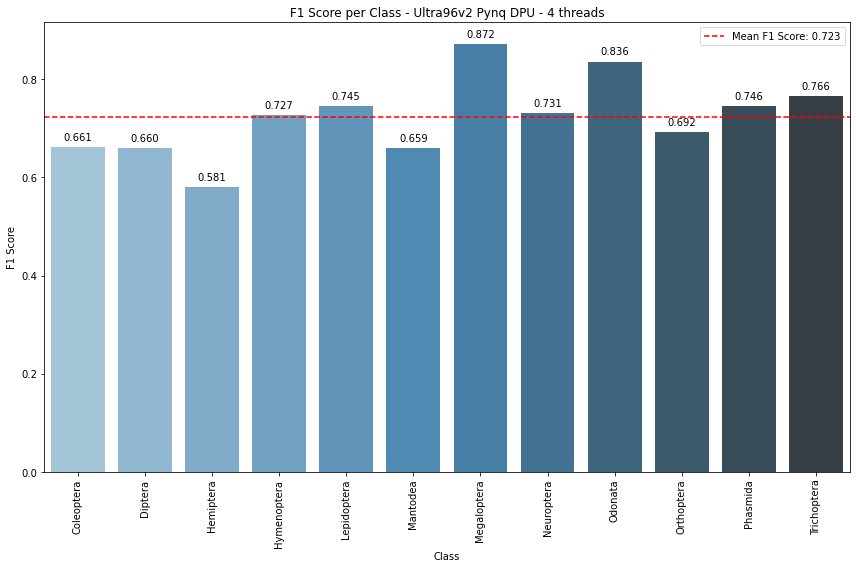

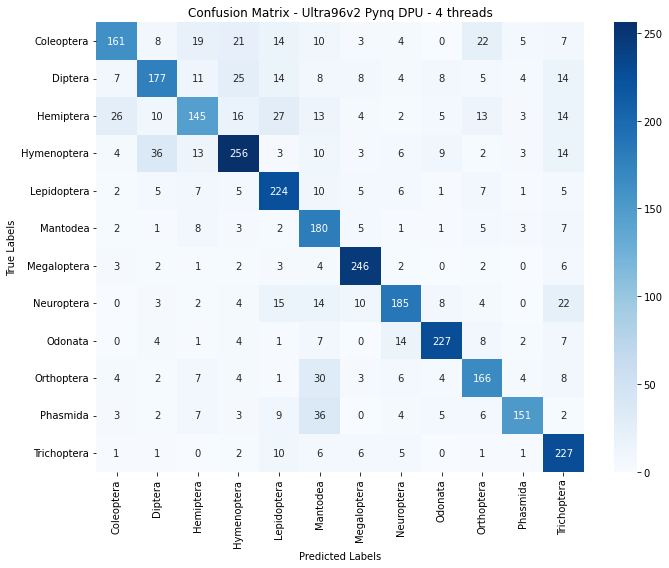

In [16]:
# Init
board = "Ultra96v2 Pynq DPU"
image_folder = "tipu12/test"
class_file = "tipu12_class_to_order.txt"

# Load class names from the class_map file
with open(class_file, "r") as file:
    class_names = [line.strip() for line in file.readlines()]

num_classes = count_directories(image_folder)
num_thread = 4

show_all_info = False
evaluate_on_thread_range = True

if evaluate_on_thread_range==True:
    for i in range(num_thread):
        accuracy, class_accuracy, label_names, predictions_list, labels_list = test_accuracy(overlay, image_folder, num_classes, i+1, show_all_info, class_file)
        plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, i+1)
        conf_mat, f1_score, f1_score_mean = compute_f1_score(labels_list, predictions_list)
        plot_f1_score(class_names, f1_score, f1_score_mean, i+1, board)
        plot_confusion_matrix(conf_mat, class_names, i+1, board)
        
else:
    accuracy, class_accuracy, label_names, predictions_list, labels_list = test_accuracy(overlay, image_folder, num_classes, num_thread, show_all_info, class_file)
    plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread)
    conf_mat, f1_score, f1_score_mean = compute_f1_score(labels_list, predictions_list)
    plot_f1_score(class_names, f1_score, f1_score_mean, num_thread, board)
    plot_confusion_matrix(conf_mat, class_names, num_thread, board)

 We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [114]:
del overlay
del dpu

NameError: name 'dpu' is not defined